## 估计模型参数

In [44]:
from IPython.display import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import scipy.optimize as opt
import statsmodels.api as sm

%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

messages = pd.read_csv('data/hangout_chat_data.csv')

### 贝叶斯看待数据的思维

假设蹲在山皮上数羊 12, 33, 20, 29, 20, 30, 18（每天经过我面前几只羊，这么一周的数据）

按照贝叶斯的思想，数据已经定下来了，接下来我要做的就是找到参数的概率分布

我们的数据是非负的整数, 在这里我们用泊松分布（Poisson distribution）去建模. 泊松分布只需要 $\mu$ 它描述数据的均值和方差。

$$p(x \ | \ \mu) = \frac{e^{-\mu}\mu^{x}} {x!} \mbox{    for     } 
x = 0, 1, 2, \cdots$$

$$\lambda = E(x) = Var(\mu)$$

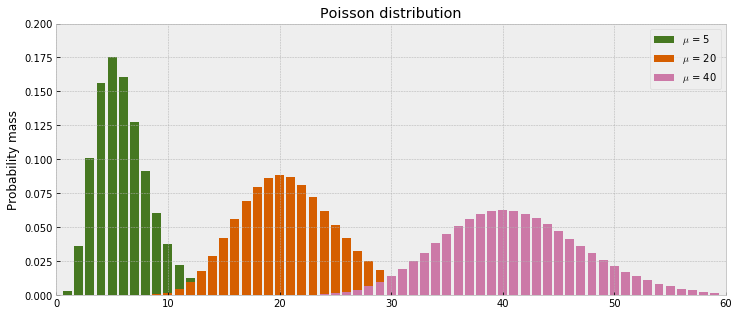

In [45]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
x_lim = 60
mu = [5, 20, 40]
for i in np.arange(x_lim):
    plt.bar(i, stats.poisson.pmf(mu[0], i), color=colors[3])
    plt.bar(i, stats.poisson.pmf(mu[1], i), color=colors[4])
    plt.bar(i, stats.poisson.pmf(mu[2], i), color=colors[5])
    
_ = ax.set_xlim(0, x_lim)
_ = ax.set_ylim(0, 0.2)
_ = ax.set_ylabel('Probability mass')
_ = ax.set_title('Poisson distribution')
_ = plt.legend(['$\mu$ = %s' % mu[0], '$\mu$ = %s' % mu[1], '$\mu$ = %s' % mu[2]])

先来看一下不同mu值得泊松分布长什么样子

回消息的反应时间的分布情况

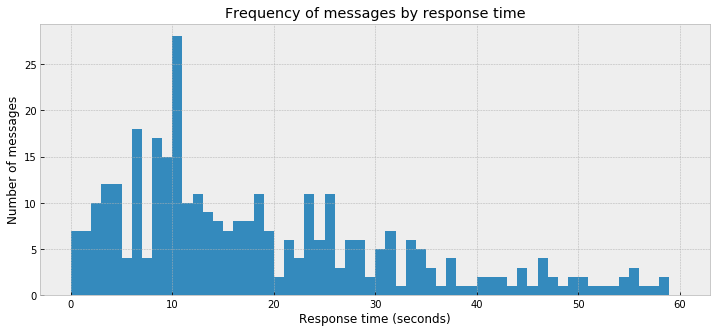

In [46]:
fig = plt.figure(figsize=(12,5))
_ = plt.title('Frequency of messages by response time')
_ = plt.xlabel('Response time (seconds)')
_ = plt.ylabel('Number of messages')
_ = plt.hist(messages['time_delay_seconds'].values, 
             range=[0, 60], bins=60, histtype='stepfilled')

### 极大似然估计求解 $\mu$

在用贝叶斯之前，先来用一下最大似然估计来求解

-  `poisson_logprob()` 根据泊松模型和参数值返回观测数据的总似然值。
-  `opt.minimize_scalar` 找到最合适的取值.

In [47]:
y_obs = messages['time_delay_seconds'].values

def poisson_logprob(mu, sign=-1):
    return np.sum(sign*stats.poisson.logpmf(y_obs, mu=mu))

freq_results = opt.minimize_scalar(poisson_logprob)
%time print("The estimated value of mu is: %s" % freq_results['x'])

The estimated value of mu is: 18.2307692324
Wall time: 1.5 ms


得到结果 $\mu$ is 18.2307692324. 但是仅仅是一个值！

下个这个图就展示了我们的过程，不断爬坡的一个过程。

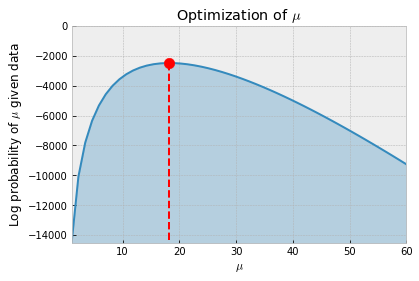

In [48]:
x = np.linspace(1, 60)
y_min = np.min([poisson_logprob(i, sign=1) for i in x])
y_max = np.max([poisson_logprob(i, sign=1) for i in x])
fig = plt.figure(figsize=(6,4))
_ = plt.plot(x, [poisson_logprob(i, sign=1) for i in x])
_ = plt.fill_between(x, [poisson_logprob(i, sign=1) for i in x], 
                     y_min, color=colors[0], alpha=0.3)
_ = plt.title('Optimization of $\mu$')
_ = plt.xlabel('$\mu$')
_ = plt.ylabel('Log probability of $\mu$ given data')
_ = plt.vlines(freq_results['x'], y_max, y_min, colors='red', linestyles='dashed')
_ = plt.scatter(freq_results['x'], y_max, s=110, c='red', zorder=3)
_ = plt.ylim(ymin=y_min, ymax=0)
_ = plt.xlim(xmin=1, xmax=60)

带入参数后分布的样子

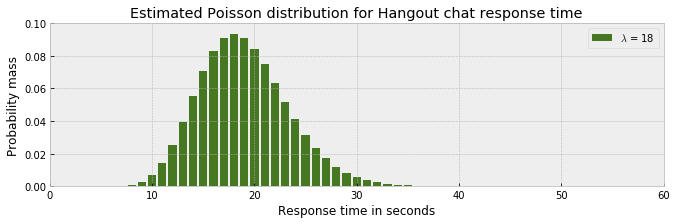

In [49]:
fig = plt.figure(figsize=(11,3))
ax = fig.add_subplot(111)
x_lim = 60
mu = np.int(freq_results['x'])
for i in np.arange(x_lim):
    plt.bar(i, stats.poisson.pmf(mu, i), color=colors[3])
    
_ = ax.set_xlim(0, x_lim)
_ = ax.set_ylim(0, 0.1)
_ = ax.set_xlabel('Response time in seconds')
_ = ax.set_ylabel('Probability mass')
_ = ax.set_title('Estimated Poisson distribution for Hangout chat response time')
_ = plt.legend(['$\lambda$ = %s' % mu])

上述泊松分布模型和 μ 的估计表明，观测小于10 或大于 30 的可能性很小，绝大多数的概率分布在 10 和 30 之间。但是，这不能反映我们观测到的介于 0 到 60 之间的数据。

### 贝叶斯方法估计 $\mu$

 
$$\overbrace{p(\mu \ |\ Data)}^{\text{posterior}} = \dfrac{\overbrace{p(Data \ | \ \mu)}^{\text{likelihood}} \cdot \overbrace{p(\mu)}^{\text{prior}}}{\underbrace{p(Data)}_{\text{marginal likelihood}}}$$

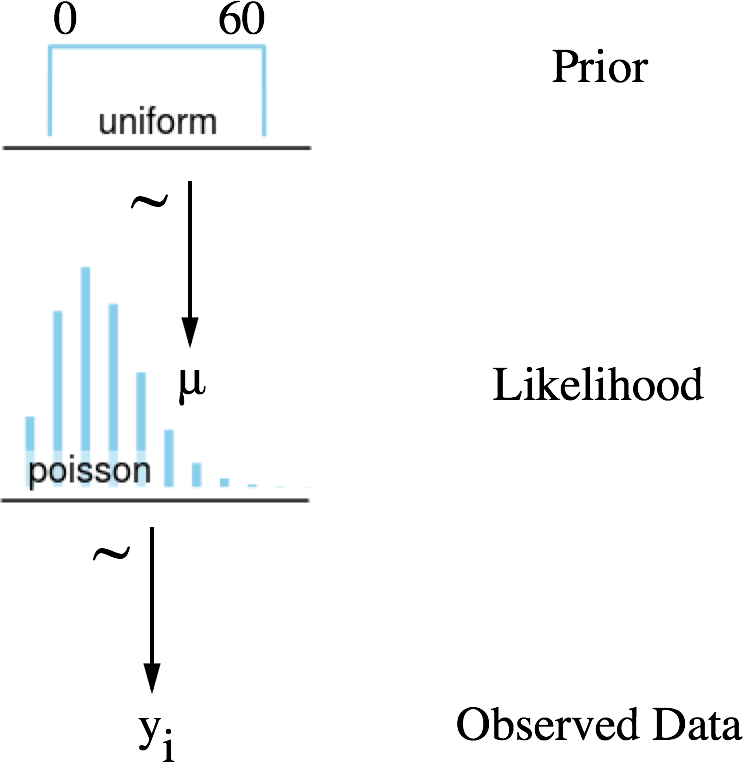

In [50]:
Image('graphics/Poisson-dag.png', width=420)

啥意思啊！解释一下吧：

- 我们得到的是计数数据。
- 这个数据是由一个随机过程生成的，我们认为它可以表示为泊松分布（可能性）。
- 这个泊松分布有一个参数 $\mu$ 我们知道它是在 0 到 60 (Prior)
- 均匀分布的原因在于并没有提及到任何条件

### 马尔科夫链蒙特卡洛方法MCMC
贝叶斯公式里的  只是一个参数，但是如果我们的问题涉及到多个参数呢？分布的积分就应该改成多重积分，但是难点在于我们该怎么算啊！MCMC采样器从先验分布中选取参数值，计算从这些参数值决定的某个分布中得到观测数据的可能性。这个计算可以作为MCMC采样器的导引。从参数的先验分布中选取值，然后计算给定数据条件下这些参数值可能性——导引采样器到更高概率的区域。与上面讨论的频率论优化技术在概念上有相似之处，MCMC采样器向可能性最高的区域运动。但是，贝叶斯方法不关心寻找绝对最大值，而是遍历和收集概率最高区域附近的样本。所有收集到的样本都可认为是一个可信的参数

#### 蒙特卡洛方法

蒙特卡洛方法是一系列应用非常广泛的算法，其思想是通过随机采样来计算或模拟给定过程。尽管很多问题都难以求解甚至无法准确用公式表达，但我们可以通过采样或者模拟来有效地研究

统计模拟中有一个重要的问题就是给定一个概率分布p(x)，我们如何在计算机中生成它的样本。其基本思想是通过大量取样来近似得到想要的答案，有一个经典的试验就是计算圆周率，在一个边上为1的正方形中画一个内切圆，现在在正方形内产生大量随机数，最后我们只需要计算在圆内点的个数比上总体点的个数，便近似得到了圆周率的值。


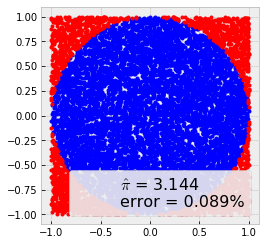

In [70]:
#每一次结果会不一样，样本越多必然也会越准确
N = 10000

x, y = np.random.uniform(-1, 1, size=(2, N))
inside = (x**2 + y**2)<= 1
pi = inside.sum()*4/N
error = abs((pi - np.pi)/pi)* 100

outside = np.invert(inside)

plt.plot(x[inside], y[inside], 'b.')
plt.plot(x[outside], y[outside], 'r.')
plt.plot(0, 0, label='$\hat \pi$ = {:4.3f}\nerror = {:4.3f}%'.
format(pi, error), alpha=0)
plt.axis('square')
plt.legend(frameon=True, framealpha=0.9, fontsize=16);

#### 马氏链的平稳性

对于我们的先验分布，如果我们能找到一个转移矩阵，那么我们就会在n步之后就会收敛到一个平稳分布，而这个分布就是我们要的后验分布。得到平稳分布后，根据平稳性，继续乘上这个转移概率矩阵，平稳分布依然不会改变，所以我们就从得到平稳分布开始每次对其进行抽样。

<img src="./img/3.png" style="width:400px;height:220px;float:left">

<img src="./img/4.png" style="width:250px;height:250px;float:left">

In [52]:
Image(url='graphics/mcmc-animate.gif')

上面的动画很好的演示了马尔科夫链蒙特卡罗方法（MCMC）的过程。MCMC采样器从先验分布中选取参数值，计算从这些参数值决定的某个分布中得到观测数据的可能性。

这个计算可以作为MCMC采样器的导引。从参数的先验分布中选取值，然后计算给定数据条件下这些参数值可能性——导引采样器到更高概率的区域。

In [53]:
with pm.Model() as model:
    mu = pm.Uniform('mu', lower=0, upper=60)
    likelihood = pm.Poisson('likelihood', mu=mu, observed=messages['time_delay_seconds'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(20000, step, start=start, progressbar=True)

logp = -3,398.7, ||grad|| = 1,989: 100%|████████████████████████████████████████████████| 7/7 [00:00<00:00, 146.98it/s]
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mu_interval__]
The number of effective samples is smaller than 10% for some parameters.


上面的代码通过遍历 μ 的后验分布的高概率区域，收集了 200,00 个 μ 的可信样本。下图（左）显示这些值的分布，平均值与频率论的估值（红线）几乎一样。但是，我们同时也得到了不确定度，μ 值介于 17 到 19 之间都是可信的。我们稍后会看到这个不确定度很有价值。

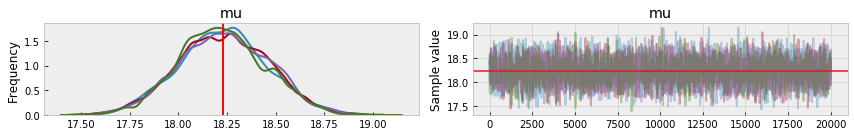

In [54]:
_ = pm.traceplot(trace, varnames=['mu'], lines={'mu': freq_results['x']})

## 贝叶斯概率编程

贝叶斯统计的概念很简单，我们有一些固定的数据（固定的意思是指我们无法改变观测值），和一些感兴趣的参数，剩下要做的就是探索这些参数可能的取值，其中所有的不确定性都通过概率进行建模。在别的统计学范式中，未知量有多种不同的表示方式，而在贝叶斯的框架中，所有未知量都是同等对待的，如果不知道某个变量，我们就给其赋予一个概率分布。因此，贝叶斯定理就是将先验概率分布（在观测到数据之前我们对问题的理解）转化成后验分布（观测到数据之后所得到的信息），换句话说，贝叶斯统计就是一种机器学习的过程。


## PyMC3

PyMC3是一个用于概率编程的Python库，PyMC3提供了一套非常简洁直观的语法，非常接近统计学中描述概率模型的语法，可读性很高。PyMC3是用Python写的，其中的核心计算部分基于NumPy和Theano。Theano是一个用于深度学习的Python库，可以高效地定义、优化和求解多维数组的数学表达式。PyMC3使用Theano的主要原因是某些采样算法（如NUTS）需要计算梯度，而Theano可以很方便地进行自动求导。而且，Theano将Python代码转化成了C代码，因而PyMC3的速度相当快。


In [31]:
#我们自己定义一个抛硬币问题，那我们就假设知道真实的参数θ，用theta_real来表示
np.random.seed(1)
n_experiments = 100
theta_real = 0.35
data = stats.bernoulli.rvs(p=theta_real, size=n_experiments)
print(data)

[0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 1 0 1 1 1 0 0 0 1 0 0 1 0 1 0 1
 1 0 1 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 1 0 0 1
 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0]


现在有了数据，需要再指定模型。回想一下，模型可以通过指定似然和先验的概率分布完成。对于似然，我们可以用二项分布来描述，对于先验，我们可以用参数为α=β=1的beta分布描述。这个beta分布与[0,1]区间内的均匀分布是一样的。我们可以用数学表达式描述如下：

<img src="./img/5.png" style="width:200px;height:60px;float:left">

In [32]:
with pm.Model() as our_first_model: #构建了一个模型的容器，PyMC3使用with语法将所有位于该语法块内的代码都指向同一个模型
    theta = pm.Beta('theta', alpha=1, beta=1) #指定先验
    y = pm.Bernoulli('y', p=theta, observed=data) #用跟先验相同的语法描述了似然，唯一不同的是我们用observed变量传递了观测到的数据
    start = pm.find_MAP() #返回最大后验（Maximum a Posteriori，MAP），为采样方法提供一个初始点
    step = pm.Metropolis() #定义了采样方法，Metropolis-Hastings算法，其实PyMC3也会根据不同参数的特性自动地赋予一个采样器
    trace = pm.sample(1000, step=step, start=start) #执行推断，其中第1个参数是采样次数，第2个和第3个参数分别是采样方法和初始点

logp = -69.315, ||grad|| = 14: 100%|████████████████████████████████████████████████████| 7/7 [00:00<00:00, 933.79it/s]
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta_logodds__]
The number of effective samples is smaller than 25% for some parameters.


### 诊断采样过程

现在我们根据有限数量的样本对后验做出了近似，接下来要做的第一件事就是检查我们的近似是否合理。我们可以做一些测试，有些是可视化的，有些是定量的。这些测试会尝试从样本中发现问题，但并不能证明我们得到的分布是正确的，它们只能提供证据证明样本看起来是合理的。如果我们通过样本发现了问题，解决办法有如下几种。

- 增加样本次数。
- 从样本链（迹）的前面部分去掉一定数量的样本，称为老化（Burn-in）。
- 重新参数化你的模型，也就是说换一种不同但却等价的方式描述模型。

#### 收敛性
通常，我们要做的第一件事就是查看结果长什么样，traceplot函数非常适合该任务：

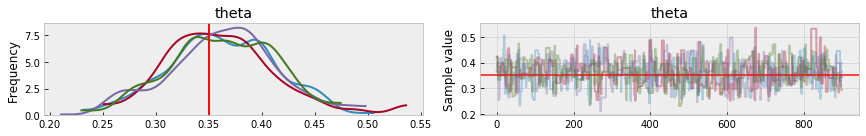

In [33]:
burnin = 100
chain = trace[burnin:]
pm.traceplot(chain, lines={'theta':theta_real});

对于未观测到的变量，我们得到了两幅图。左图是一个核密度估计（Kernel Density Estimation，KDE）图。右图描绘的是每一步采样过程中得到的采样值。注意图中红色的线表示变量theta_real的值。

在得到这些图之后，我们需要观察什么呢？首先，KDE图看起来应该是光滑的曲线。通常，随着数据的增加，根据中心极限定理，参数的分布会趋近于高斯分布。右侧的图看起来应该像白噪声，也就是说有很好的混合度（mixing），我们看不到任何可以识别的模式，也看不到向上或者向下的曲线，相反，我们希望看到曲线在某个值附近震荡。对于多峰分布或者离散分布，我们希望曲线不要在某个值或区域停留过多时间，我们希望看到采样值在多个区间自由移动。此外，我们希望迹表现出稳定的相似性，也就是说，前10%看起来跟后50%或者10%差不多。再次强调，我们不希望看到规律的模式，相反我们期望看到的是噪声。下图展示了一些迹呈现较好混合度（右侧）与较差混合度（左侧）的对比。

<img src="./img/6.png" style="width:600px;height:350px;float:left">

如果迹的前面部分跟其他部分看起来不太一样，那就意味着需要进行老化处理，如果其他部分没有呈现稳定的相似性或者可以看到某种模式，那这意味着需要更多的采样，或者需要更换采样方法或者参数化方法。对于一些复杂的模型，我们可能需要结合使用前面所有的策略。

一种定量地检测收敛性的方法是Gelman-Rubin检验。该检验的思想是比较不同迹之间的差异和迹内部的差异，因此，需要多组迹来进行该检验。理想状态下，我们希望得到R=1，根据经验，如果得到的值低于1.1，那么可以认为是收敛的了，更高的值则意味着没有收敛。

In [35]:
pm.gelman_rubin(chain)

{'theta': 0.99949808854882483}

函数summary提供了对后验的文字描述，它可以提供后验的均值、标准差和HPD区间（最大后验密度可信区间）：

In [37]:
pm.summary(chain)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta,0.362403,0.050307,0.001756,0.263543,0.456768,644.0,0.999498


其中，返回值之一是mc_error，这是对采样引入误差的估计值，该值考虑的是所有的采样值并非真的彼此独立。mc_error是迹中不同块的均值的标准差，每一块是迹中的一部分。

#### 自相关
最理想的采样应该不会是自相关的，也就是说，某一点的值应该与其他点的值是相互独立的。由于参数之间的相互依赖关系，可能模型会导致更多的自相关采样。PyMC3有一个很方便的函数用来描述自相关。


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019910B51C50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000019910669080>]], dtype=object)

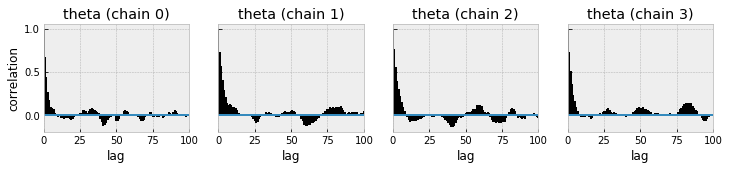

In [38]:
pm.autocorrplot(chain)

该图显示了采样值与相邻连续点（最多100个）之间的平均相关性。理想状态下，我们不会看到自相关性，实际中我们希望看到自相关性降低到较低水平。参数越自相关，要达到指定精度的采样次数就需要越多，也就是说，自相关性不利于降低采样次数。

#### 有效采样大小
一个有自相关性的采样要比没有自相关性的采样所包含的信息量更少，因此，给定采样大小和采样的自相关性之后，我们可以尝试估计出该采样的大小为多少时，该采样没有自相关性而且包含的信息量不变，该值称为有效采样大小。理想情况下，两个值是一模一样的；二者越接近，我们的采样效率越高。有效采样大小可以作为我们的一个参考，如果我们想要估计出一个分布的均值，我们需要的最小采样数至少为100；如果想要估计出依赖于尾部分布的量，比如可信区间的边界，那么我们可能需要1000到10000次采样。

In [40]:
pm.effective_n(chain)['theta']

644.0

显然，提高采样效率的一个方法是换一个更好的采样方法；另一个办法是转换数据或者对模型重新设计参数。

目前为止，所有的诊断测试都是经验性而非绝对的。实际使用中，我们会先运行一些测试，如果看起来没什么问题，我们就继续往下分析。如果发现了一些问题，就需要回过头解决它们，这也是建模过程的一部分。要知道，进行收敛性检查并非贝叶斯理论的一部分，由于我们是用数值的方式在计算后验，因而这只是贝叶斯实践过程中的一部分。

#### 总结后验

我们已经知道，贝叶斯分析的结果是后验分布，其包含了在已有数据和模型下，参数的所有信息。我们可以使用PyMC3中的plot_posterior函数对后验分布进行可视化总结，这个函数的核心参数是一个PyMC3的迹和或者一个NumPy的数组，默认情况下，该函数会画出参数的直方图以及分布的均值，此外图像的底端还有一个黑色的粗线用来表示95%HPD区间。


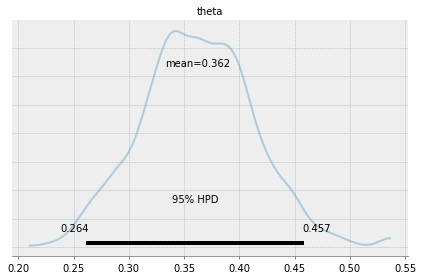

In [41]:
pm.plot_posterior(chain, kde_plot=True)

#### 基于后验的决策

有时候，仅仅描述后验还不够，我们还需要根据推断结果做决策，即将连续的估计值收敛到一个二值化结果上：是或不是、受污染了还是安全的等等。回到抛硬币问题上，我们需要回答硬币是不是公平的。一枚公平的硬币是指θ 的值为0.5，严格来说，出现这种情况的概率是0，因而，实际中我们会对定义稍稍放松，假如一枚硬币的θ 值在0.5左右，我们就认为这枚硬币是公平的。这里“左右”的具体含义依赖于具体的问题，并没有一个满足所有问题的普适准则。因此决策也是偏主观的，我们的任务就是根据我们的目标做出最可能的决策。

直观上，一个明智的做法是将HPD区间与我们感兴趣的值进行比较，在我们的例子中，该值是0.5。前面的图中可以看出HPD的范围是0.264～0.457，没有包含0.5这个值，裁定一个硬币是不公平的。

#### 实用等价区间

基于后验做决策的一种方案是实用等价区间（Region Of Practical Equivalence，ROPE），其实就是在感兴趣值附近的一个区间，例如我们可以说[0.45,0.55]是0.5的一个实用性等价区间。同样，ROPE是根据实际情况决定的。接下来我们可以将ROPE与HPD对比，结果至少有以下3种情况。

- ROPE与HPD区间没有重叠，因此我们可以说硬币是不公平的
- ROPE包含整个HPD区间，我们可以认为硬币是公平的。
- ROPE与HPD区间部分重叠，此时我们不能判断硬币是否公平。

当然，如果选择区间[0,1]作为ROPE，那么不管结果怎样我们都会说这枚硬币是公平的，不过恐怕没人会同意我们对ROPE的定义。plot_posterior函数可以用来画ROPE。从图中可以看到，ROPE是一段较宽的半透明的红色线段，同时上面有两个数值表示ROPE的两个端点。

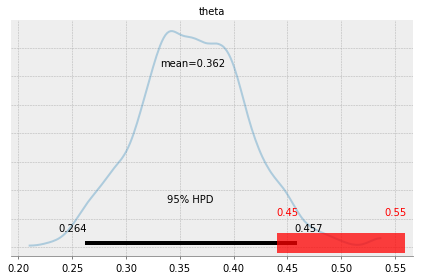

In [42]:
pm.plot_posterior(chain, kde_plot=True, rope=[0.45, 0.55])